# Downloads raw data

In [9]:
import API.send_request as req
import json

# match information
match_id = 'KR_5558295613'
server = 'asia'
api_key = 'RGAPI-85d268e0-af2f-4ea8-8879-3275e9f111fb'
save_path = '../../Dataset/League_of_Legends/challenger_raw/'

sender = req.match_req_sender(server, api_key)
meta = sender.req_match(match_id)
timeline = sender.req_timeline(match_id)

if (meta != None and timeline != None):
    meta = meta.json()
    timeline = timeline.json()

    # save json file
    with open(save_path+f"{match_id}.json", "w") as file_match:
        json.dump(meta, file_match, indent=4)

    with open(save_path+f"{match_id}_timeline.json", "w") as file_timeline:
        json.dump(timeline, file_timeline, indent=4)

Got match data with match id=KR_5558295613 successfuly.
Got timeline data with match id=KR_5558295613 successfuly.


# Extract features

In [10]:
%rm -rf ../../Dataset/League_of_Legends/challenger_raw/.ipynb_checkpoints

from Utilities.timeline_extractor import extract
from Utilities.win_lose_extractor import challengers

extract('../../Dataset/League_of_Legends', '/challenger_raw/', '/challenger_csv/')
challengers()

100%|██████████| 20/20 [00:00<00:00, 6212.86it/s]


# Tensorize

In [11]:
%rm -rf ../../Dataset/League_of_Legends/challenger_csv/.ipynb_checkpoints

import pandas as pd
from os import listdir
from tqdm import tqdm
from torch import tensor, zeros

pickle_route = "../../Dataset/League_of_Legends/features_tensor/challenger/"

print("Processing flipped train features...")
csv_route = "../../Dataset/League_of_Legends/challenger_csv/"
feat_list = listdir(csv_route)

for file_name in tqdm(feat_list):
    file = pd.read_csv(f"{csv_route}{file_name}")
    file = file.sort_values(by='time', ascending=False, axis=0, ignore_index=True)
    file = file[file['is_valid'] == True]
    file = file.loc[:,"time":"event_weight"]
    players = []
    for idx in range(0, 10):
        player = file[file["player"] == idx+1].drop(columns=["player"])
        temp_feature = tensor([player.values]) if len(player) != 0 else zeros([1, 1, 30])
        # if temp_feature.size()[1] > 1: temp_feature = temp_feature.flip(1)
        players.append(temp_feature)
    pd.to_pickle(players, f"{pickle_route}{file_name[0:-4]}.pkl")
print("")

Processing flipped train features...


100%|██████████| 10/10 [00:00<00:00, 111.35it/s]

# Tensorize (by team)

In [12]:
%rm -rf ../../Dataset/League_of_Legends/challenger_csv/.ipynb_checkpoints

import pandas as pd
from os import listdir
from tqdm import tqdm
from torch import tensor, zeros

csv_route = "../../Dataset/League_of_Legends/challenger_csv/"
pickle_route = "../../Dataset/League_of_Legends/features_tensor/challenger_by_team/"
feat_list = listdir(csv_route)

print("Processing flipped test features...")

for file_name in tqdm(feat_list):
    f_file = pd.read_csv(f"{csv_route}{file_name}")
    f_file = f_file.loc[:,"time":"event_weight"]

    blue = f_file[f_file['player'] < 5].drop(columns=['player'])
    red = f_file[f_file['player'] >= 5].drop(columns=['player'])

    blue_features = tensor([blue.values]) if len(blue) != 0 else zeros([1, 1, 30])
    if blue_features.shape[1] > 1: blue_features = blue_features.flip(1)

    red_features = tensor([red.values]) if len(red) != 0 else zeros([1, 1, 30])
    if red_features.shape[1] > 1: red_features = red_features.flip(1)

    features = [blue_features, red_features]
    pd.to_pickle(features, f"{pickle_route}{file_name[0:-4]}.pkl")
print("")

Processing flipped test features...


100%|██████████| 10/10 [00:00<00:00, 192.19it/s]

# Test


In [13]:
import pasta_spaghettini_g3 as spa
from tqdm import tqdm
import pandas as pd
import torch

hp = {"epochs": 1, "learning_rate": 0.01, "num_layers": 2, "hidden_size": 8, "input_size": 30}
PASTA = spa.PASTA(hp["input_size"], hp["hidden_size"], hp["num_layers"], hp["learning_rate"])

route = "../../Dataset/League_of_Legends/features_tensor/challenger_by_team/"

test_match_result_ftr = pd.read_csv("./processed_csvs/challenger_result.csv")
total_rows = test_match_result_ftr.shape[0]

PASTA.load_parameter('./parameters/param_spa_g3')
confusion_matrix, c_label = [0, 0, 0, 0], ["TN", "FP", "FN", "TP"]

print("--test start--")
for idx, row in tqdm(test_match_result_ftr.iterrows(), ncols=50, total=total_rows):
    match_id, win = row["match_no"], row["win"]
    features = pd.read_pickle(f"{route}{match_id}.pkl")
    # winner, predict = PASTA.test(features, win, match_id, postfix='challenger')
    winner, predict = PASTA.test(features, win, match_id)
    correct = 2*winner + predict
    confusion_matrix[correct] += 1

for idx in range(0, 4):
    print(f"{c_label[idx]}: {confusion_matrix[idx]} / ", end="")
    
torch.cuda.empty_cache()

--test start--


100%|█████████████| 10/10 [00:00<00:00, 40.21it/s]

TN: 6 / FP: 0 / FN: 0 / TP: 4 / 

# Extract metadata

In [14]:
%rm -rf ./processed_csvs/challengers/*
%rm -rf ../../Dataset/League_of_Legends/challenger_raw/.ipynb_checkpoints

import Utilities.meta_extractor as me
import Utilities.meta_analyzer as ma
import Utilities.meta_concat_total_score as mc

me.extract()
ma.analyze()
mc.concat(g3=True)

# Challenger games list

In [7]:
%rm -rf ../../Dataset/League_of_Legends/features_tensor/challenger_by_team/.ipynb_checkpoints

import pandas as pd
from os import listdir

path = '../../Dataset/League_of_Legends/features_tensor/challenger_by_team/'
games = listdir(path)
games

['KR_5548846548.pkl',
 'KR_5534775864.pkl',
 'KR_5534661935.pkl',
 'KR_5531638748.pkl',
 'KR_5534298194.pkl',
 'KR_5534402610.pkl',
 'KR_5531651538.pkl',
 'KR_5548791013.pkl',
 'KR_5550089007.pkl']

# Score analysis

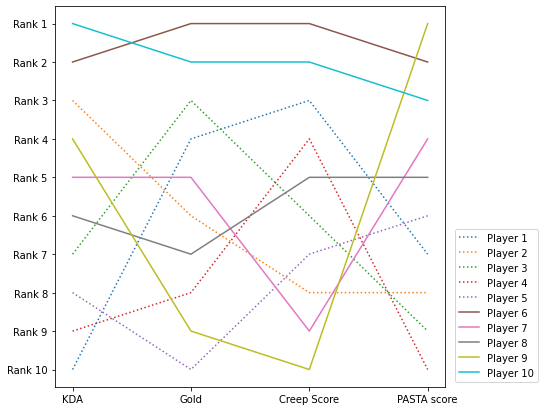

In [15]:
import experiment_vis_leaderboard as lb
import matplotlib.pyplot as plt

# match = 'KR_5531638748' # Plaayer 5: Not very good according to traditional indicators, but PASTA score is high
# match = 'KR_5548791013'
match = 'KR_5558295613'

data, isWin = lb.load_leaderboard_graph(match, challenger=True)

players = []
for index, series in data.iterrows():
    ranks = series.tolist()
    ranks = [11-rank for rank in ranks]
    players.append(ranks)

x_axis = data.columns.tolist()

fig = plt.figure(figsize=(7, 7))

##### total plot #####
for i in range(len(players)):
    line = '-' if isWin[i] else ':'
    plt.plot(x_axis, players[i], linestyle=line, label=f'Player {i+1}')
plt.yticks([i+1 for i in range(10)], [f'Rank {10-i}' for i in range(10)])
plt.legend(bbox_to_anchor=(0.5, 0, 0.75, 0), loc='lower right')
    
plt.show()

In [16]:
import experiment_vis_leaderboard as lb
import matplotlib.pyplot as plt

match = 'KR_5558295613'

data = lb.load_leaderboard(match, challenger=True)
data.drop(labels='sum of ranks', axis='columns', inplace=True)
data = data[['KDA', 'Gold Earn & Spend', 'totalMinionsKilled', 'total score']]
data

,KDA,Gold Earn & Spend,totalMinionsKilled,total score
Rank 1,Player 10,Player 6,Player 6,Player 9
Rank 2,Player 6,Player 10,Player 10,Player 6
Rank 3,Player 2,Player 3,Player 1,Player 10
Rank 4,Player 9,Player 1,Player 4,Player 7
Rank 5,Player 7,Player 7,Player 8,Player 8
Rank 6,Player 8,Player 2,Player 3,Player 5
Rank 7,Player 3,Player 8,Player 5,Player 1
Rank 8,Player 5,Player 4,Player 2,Player 2
Rank 9,Player 4,Player 9,Player 7,Player 3
Rank 10,Player 1,Player 5,Player 9,Player 4


# Scores per events of a player

In [11]:
import pandas as pd

score_path = './processed_ftr/challenger_g3_score.csv' # PASTA by team
# score_path = './processed_ftr/scores_challenger.csv' # PASTA by player
match_id = 'KR_5548791013'
player = 1

pd.set_option("display.max_rows", None, "display.max_columns", None)
events = ['ITEM_PURCHASED', 'ITEM_SOLD',
       'ITEM_DESTROYED', 'SKILL_LEVEL_UP', 'LEVEL_UP', 'WARD_PLACED',
       'WARD_KILL', 'CHAMPION_KILL', 'CHAMPION_KILL_ASSIST',
       'CHAMPION_KILL_VICTIM', 'BUILDING_KILL', 'BUILDING_KILL_ASSIST',
       'ELITE_MONSTER_KILL', 'ELITE_MONSTER_KILL_ASSIST']

data = pd.read_csv(score_path)

data = data[(data['match_id'] == match_id) & (data['player'] == player)].drop(labels=['match_id', 'win'], axis='columns')
data = data.drop(labels=['mage', 'fighter', 'support', 'tank', 'assassin', 'marksman', 'TOP', 'MIDDLE', 'BOTTOM', 'JUNGLE', 'UTILITY'], axis='columns')

scoresums, counts, means = [], [], []
for event in events:
    event_scores = data[data[event] == 1]['score'].tolist()
    
    _sum = sum(event_scores)
    _count = len(event_scores)
    _mean = _sum / _count if _count != 0 else 0
    
    scoresums.append(_sum)
    counts.append(_count)
    means.append(_mean)
    
scoresum_per_event = {
    'event': events, 'sum of score': scoresums, 'count': counts, 'mean': means
}
scoresum_per_event = pd.DataFrame(scoresum_per_event).sort_values(by='sum of score', axis=0, ascending=False, ignore_index=True)
scoresum_per_event

,event,sum of score,count,mean
0,SKILL_LEVEL_UP,12.528236,10,1.252824
1,LEVEL_UP,9.962040,10,0.996204
2,ITEM_PURCHASED,8.642503,10,0.864250
3,CHAMPION_KILL,6.501513,7,0.928788
4,ITEM_DESTROYED,5.440535,7,0.777219
5,WARD_KILL,4.433653,5,0.886731
6,CHAMPION_KILL_ASSIST,4.260519,4,1.065130
7,WARD_PLACED,4.237975,5,0.847595
8,CHAMPION_KILL_VICTIM,3.317939,5,0.663588
9,ITEM_SOLD,0.000000,0,0.000000


# Average scores per player for a event

In [13]:
import pandas as pd

score_path = './processed_ftr/challenger_g3_score.csv' # PASTA by team
# score_path = './processed_ftr/scores_challenger.csv' # PASTA by player
match_id = 'KR_5548791013'
event = 'SKILL_LEVEL_UP'

pd.set_option("display.max_rows", None, "display.max_columns", None)

data = pd.read_csv(score_path)

data = data[(data['match_id'] == match_id)].drop(labels=['match_id', 'win'], axis='columns')
data = data.drop(labels=['mage', 'fighter', 'support', 'tank', 'assassin', 'marksman', 'TOP', 'MIDDLE', 'BOTTOM', 'JUNGLE', 'UTILITY'], axis='columns')

scoresums, counts, means = [], [], []
data = data[data['SKILL_LEVEL_UP'] == 1]
for player in range(10):
    event_scores = data[data['player'] == player+1]['score'].tolist()
    
    _sum = sum(event_scores)
    _count = len(event_scores)
    _mean = _sum / _count if _count != 0 else 0
    
    scoresums.append(_sum)
    counts.append(_count)
    means.append(_mean)
    
scoresum_per_event = {
    'player': [i+1 for i in range(10)], 'sum of score': scoresums, 'count': counts, 'mean': means
}
scoresum_per_event = pd.DataFrame(scoresum_per_event).sort_values(by='player', axis=0, ascending=True, ignore_index=True)
scoresum_per_event

,player,sum of score,count,mean
0,1,12.528236,10,1.252824
1,2,7.172097,6,1.195350
2,3,9.984777,8,1.248097
3,4,26.345966,20,1.317298
4,5,15.849938,12,1.320828
5,6,4.007821,7,0.572546
6,7,11.824538,17,0.695561
7,8,7.382268,12,0.615189
8,9,5.564047,8,0.695506
9,10,7.729924,12,0.644160


# Event sequence of a player

In [16]:
import pandas as pd

score_path = './processed_ftr/challenger_g3_score.csv' # PASTA by team
# score_path = './processed_ftr/scores_challenger.csv' # PASTA by player
match_id = 'KR_5548791013'
player = 1

pd.set_option("display.max_rows", None, "display.max_columns", None)
events = ['ITEM_PURCHASED', 'ITEM_SOLD',
       'ITEM_DESTROYED', 'SKILL_LEVEL_UP', 'LEVEL_UP', 'WARD_PLACED',
       'WARD_KILL', 'CHAMPION_KILL', 'CHAMPION_KILL_ASSIST',
       'CHAMPION_KILL_VICTIM', 'BUILDING_KILL', 'BUILDING_KILL_ASSIST',
       'ELITE_MONSTER_KILL', 'ELITE_MONSTER_KILL_ASSIST']

data = pd.read_csv(score_path)
data = data[(data['match_id'] == match_id) & (data['player'] == player)]
data.sort_values(by='time', inplace=True, ignore_index=True)

event_seq = []
for i in range(data.shape[0]):
    seq = {
        'time': data.loc[i, 'time'],
        'score': data.loc[i, 'score']
    }
    for event in events:
        if data.loc[i, event] == 1: seq['event'] = event
    event_seq.append(seq)

event_seq = pd.DataFrame(event_seq)
event_seq

,time,score,event
0,0.003605,0.827472,ITEM_PURCHASED
1,0.017420,1.257649,SKILL_LEVEL_UP
2,0.052935,0.949729,WARD_PLACED
3,0.065264,1.251658,SKILL_LEVEL_UP
4,0.071497,0.945263,LEVEL_UP
5,0.073941,1.253748,SKILL_LEVEL_UP
6,0.080929,0.769779,ITEM_DESTROYED
7,0.091226,0.806830,LEVEL_UP
8,0.107048,0.662193,ITEM_DESTROYED
9,0.109173,0.658764,CHAMPION_KILL_ASSIST
